<a href="https://colab.research.google.com/github/HEYanTao/AssetLocationSimulation/blob/main/Intuition_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intuition Experiments

Experiment A: Financial planning intuition.
Assume no market regime change (simple environment) and fix the goal, train an agent to test:
1. Agent's behaviour when it has the same balance but different age
2. Agent's behaviour when it has the same age but different balance

In [ ]:
import stable_baselines3
stable_baselines3.__version__
import gym
import json
import datetime as dt
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
class AssetAllocationSimpleEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']} ## This means the print out will be in a fashion for human read

    def __init__(self): #can pass in real data in the challangeing environment
        super(AssetAllocationSimpleEnvironment, self).__init__()

        self.reward_range = (0, 100) #Doesn't seem necessary

        self.state1_equity_mean = 0.10 # equity has 10% mean return
        self.state1_equity_sd = 0.18/2 # equity has 18% standard deviation
        self.state1_bond_mean = 0.035 # bond has 3.5% mean return
        self.state1_bond_sd = 0.035 # bond has 3.5% standard deviation
        self.state1_cash_mean = 0.005 # cash has 0.5% mean return
        self.state1_cash_sd = 0.0 # cash has 0% standard deviation
        self.annual_trading_days = 252 # 252 traading days per year
        self.current_step = np.random.normal(0,1,(252,3))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.state1_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.state1_equity_sd/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.state1_bond_mean/self.annual_trading_days + self.current_step[:,1] * (self.state1_bond_sd/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 30 # start at 40 years old
        self.goal = 70 #reach 99 MV or more
        self.balance = np.array([5.0],dtype = np.float64) #start with 1 in MV
        self.port_weights = np.array([0.0, 0.0, 1.0]) # start with all cash portfolio

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = gym.spaces.Box( #continous action space
          low=np.array([0, 0, 0]), high=np.array([1, 1, 1]), dtype=np.float16) #Stock, Bond, Cash

        #self.action_space = spaces.Tuple(( #discrete action space
        #    spaces.Discrete(11), #Can choose from 0%, 10%, 20%...100%
        #    spaces.Discrete(11),
        #    spaces.Discrete(11)))
        spaces = {
            'market': gym.spaces.Box(low=-1, high=1, shape=(252,3), dtype=np.float16), #252 trading days and 3 instruments. with daily returns
            'age': gym.spaces.Discrete(100), #1 to 99
            'balance': gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float64),
        }
        self.observation_space = gym.spaces.Dict(spaces)

    def _next_observation(self):
        # This is the function that generates the state output
        return_sim = np.random.normal(0,1,(252,3))#Stock, Bond, Cash
        return_sim[:,0] = self.state1_equity_mean/self.annual_trading_days + return_sim[:,0] * (self.state1_equity_sd/np.sqrt(self.annual_trading_days))
        return_sim[:,1] = self.state1_bond_mean/self.annual_trading_days + return_sim[:,1] * (self.state1_bond_sd/np.sqrt(self.annual_trading_days))
        return_sim[:,2] = self.state1_cash_mean/self.annual_trading_days + return_sim[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))
        self.current_step = return_sim
        # Append additional data and scale each value to between 0-1
        obs = {
            'market':return_sim, #TODO: remove this flatten once has custom policy
            'age':self.age,
            'balance':self.balance,
        }

        return obs

    def _take_action(self, action):
        # Update class variables based on the actions taken by agent
        self.port_weights = action #Action space is #Stock, Bond, Cash
        # If we consider transaction cost or tax, should implement here

    def _portfolio_softmax(self, x):
        # Softmax function to set the portfolio weights according to constraints
        if x.sum()<=0:
            x = np.array([0.0,0.0,1.0])
        else:
            x = x / x.sum()

        return x

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(self._portfolio_softmax(action))
        temp_portwgts = self.port_weights
        self.age += 1 #age increase

        obs = self._next_observation() #generate new year of return data

        temp_return = np.sum((self.current_step.sum(axis=0)+1)*self.port_weights)
        previous_balance = self.balance
        self.balance = self.balance * temp_return  #market value update

        # reward assignment
        if self.age > 80: #assume 80 year old is the end of the simulation, or can change to faterlity table
            done = True
            if self.balance >= self.goal: #only one type of reward for reaching the goal
                reward = 100.0
            elif self.balance >= self.goal/5:
                reward = 10.0
            elif self.balance >= self.goal/10:
                reward = 1.0
            else:
                reward = 0.0

        else:
            done = False
            temp_return = temp_return-1
            if previous_balance < self.goal:
                needed_rtn = (self.goal-previous_balance)/(previous_balance*(81-self.age))
                if temp_return>needed_rtn:
                    reward = temp_return - needed_rtn # reward for hitting goal
                else:
                    reward = 0.0 # no reward for not hitting goal
            else:
                if temp_return < self.state1_cash_mean:
                    reward = -100.0 #extra penalize taking risk after reaching goal
                else:
                    reward = 0.0 #no reward for exceeding goal

        return obs, reward, done, {'portfolio':temp_portwgts,}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.current_step = np.random.normal(0,1,(252,3))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.state1_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.state1_equity_sd/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.state1_bond_mean/self.annual_trading_days + self.current_step[:,1] * (self.state1_bond_sd/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 30 # start at 60 years old
        self.balance = np.array([5.0],dtype = np.float64) #start with 50 in MV
        self.port_weights = np.array([0.0, 0.0, 1.0]) # start with all cash portfolio

        return self._next_observation()

    def custom_reset(self,age,balance):
        # Reset the state of the environment to an initial state
        self.current_step = np.random.normal(0,1,(252,3))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.state1_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.state1_equity_sd/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.state1_bond_mean/self.annual_trading_days + self.current_step[:,1] * (self.state1_bond_sd/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = age # start at 60 years old
        self.balance = balance

        return self._next_observation()

    def render(self, mode='human', close=False):
        print(f'Current Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Age: {self.age}')
        print(f'Position: {self.port_weights}')


In [ ]:
# The algorithms require a vectorized environment to run
env = DummyVecEnv([lambda: AssetAllocationSimpleEnvironment()])


/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
from stable_baselines3.common.env_checker import check_env
env_simple = AssetAllocationSimpleEnvironment() #not vectorize
check_env(env_simple)

/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your observation market has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  f"Your observation {key} has an unconventional shape (neither an image, nor a 1D vector). "
/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:273: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [ ]:
import gym
import torch as th
from torch import nn

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, market_features_dim1: int = 128, market_features_dim2: int = 32):
        super(CustomCombinedExtractor, self).__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        # We need to know size of the output of this extractor,
        # so go over all the spaces and compute output feature sizes
        for key, subspace in observation_space.spaces.items():
            if key == "market":
                extractors[key] = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(252*3,market_features_dim1), #input size, 252*3
                    nn.Linear(market_features_dim1,market_features_dim2),
                    nn.ReLU(),
                    nn.Linear(market_features_dim2,market_features_dim2),
                    #nn.Softmax(4),
                )
                total_concat_size += market_features_dim2 #subspace.shape[1] // 4 * subspace.shape[2] // 4
            elif key == "age":
                # Just append
                extractors[key] = nn.Flatten()
                total_concat_size += subspace.n #discrete
            elif key == "balance":
                # Just append
                extractors[key] = nn.Flatten()
                total_concat_size += 1

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            encoded_tensor_list.append(extractor(observations[key]))

        return th.cat(encoded_tensor_list, dim=1)

In [ ]:
policy_kwargs = dict(
    net_arch=[128, dict(vf=[128,32], pi=[32,16])], #This changes the  neural network design for actor and critic network. This is after the feature extractor.
    features_extractor_class=CustomCombinedExtractor,
    features_extractor_kwargs=dict(market_features_dim1=32,market_features_dim2=8),
)
model_custom = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

Using cpu device


In [ ]:
model_custom.learn(total_timesteps=2000000)

-----------------------------
| time/              |      |
|    fps             | 1271 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 977          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0059636044 |
|    clip_fraction        | 0.0597       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.62        |
|    explained_variance   | 0.167        |
|    learning_rate        | 0.0003       |
|    loss                 | 882          |
|    n_updates            | 1650         |
|    policy_gradient_loss | 0.00189      |
|    std                  | 0.812        |
|    value_loss           | 987          |
----------------

----------------------------------------
| time/                   |            |
|    fps                  | 786        |
|    iterations           | 12         |
|    time_elapsed         | 31         |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.01171775 |
|    clip_fraction        | 0.0988     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.53      |
|    explained_variance   | 0.169      |
|    learning_rate        | 0.0003     |
|    loss                 | 158        |
|    n_updates            | 1750       |
|    policy_gradient_loss | 0.00815    |
|    std                  | 0.788      |
|    value_loss           | 517        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 764         |
|    iterations           | 13          |
|    time_elapsed         | 34          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 746         |
|    iterations           | 23          |
|    time_elapsed         | 63          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.010229088 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.47       |
|    explained_variance   | 0.148       |
|    learning_rate        | 0.0003      |
|    loss                 | 160         |
|    n_updates            | 1860        |
|    policy_gradient_loss | 0.00927     |
|    std                  | 0.775       |
|    value_loss           | 240         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 24          |
|    time_elapsed         | 66    

-----------------------------------------
| time/                   |             |
|    fps                  | 747         |
|    iterations           | 34          |
|    time_elapsed         | 93          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.008206708 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.38       |
|    explained_variance   | 0.147       |
|    learning_rate        | 0.0003      |
|    loss                 | 219         |
|    n_updates            | 1970        |
|    policy_gradient_loss | 0.00345     |
|    std                  | 0.75        |
|    value_loss           | 458         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 748         |
|    iterations           | 35          |
|    time_elapsed         | 95    

-----------------------------------------
| time/                   |             |
|    fps                  | 760         |
|    iterations           | 45          |
|    time_elapsed         | 121         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.013607433 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.32       |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 2080        |
|    policy_gradient_loss | 0.00365     |
|    std                  | 0.738       |
|    value_loss           | 392         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 761         |
|    iterations           | 46          |
|    time_elapsed         | 123   

-----------------------------------------
| time/                   |             |
|    fps                  | 762         |
|    iterations           | 56          |
|    time_elapsed         | 150         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.014822146 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.22       |
|    explained_variance   | 0.0561      |
|    learning_rate        | 0.0003      |
|    loss                 | 159         |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.00244     |
|    std                  | 0.71        |
|    value_loss           | 442         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 762        |
|    iterations           | 57         |
|    time_elapsed         | 153       

-----------------------------------------
| time/                   |             |
|    fps                  | 768         |
|    iterations           | 67          |
|    time_elapsed         | 178         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.014065927 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.13       |
|    explained_variance   | -0.136      |
|    learning_rate        | 0.0003      |
|    loss                 | 313         |
|    n_updates            | 2300        |
|    policy_gradient_loss | 0.00702     |
|    std                  | 0.69        |
|    value_loss           | 372         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 769         |
|    iterations           | 68          |
|    time_elapsed         | 180   

-----------------------------------------
| time/                   |             |
|    fps                  | 778         |
|    iterations           | 78          |
|    time_elapsed         | 205         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.010581463 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.97       |
|    explained_variance   | 0.161       |
|    learning_rate        | 0.0003      |
|    loss                 | 171         |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.00707     |
|    std                  | 0.659       |
|    value_loss           | 340         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 778         |
|    iterations           | 79          |
|    time_elapsed         | 207   

-----------------------------------------
| time/                   |             |
|    fps                  | 785         |
|    iterations           | 89          |
|    time_elapsed         | 232         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.009014798 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.93       |
|    explained_variance   | 0.0735      |
|    learning_rate        | 0.0003      |
|    loss                 | 156         |
|    n_updates            | 2520        |
|    policy_gradient_loss | -0.000452   |
|    std                  | 0.654       |
|    value_loss           | 473         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 785          |
|    iterations           | 90           |
|    time_elapsed         | 23

------------------------------------------
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 100          |
|    time_elapsed         | 259          |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0060860724 |
|    clip_fraction        | 0.0912       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.93        |
|    explained_variance   | 0.214        |
|    learning_rate        | 0.0003       |
|    loss                 | 157          |
|    n_updates            | 2630         |
|    policy_gradient_loss | 0.00145      |
|    std                  | 0.65         |
|    value_loss           | 422          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 790         |
|    iterations           | 101         |
|    time_elaps

----------------------------------------
| time/                   |            |
|    fps                  | 793        |
|    iterations           | 111        |
|    time_elapsed         | 286        |
|    total_timesteps      | 227328     |
| train/                  |            |
|    approx_kl            | 0.01381504 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85      |
|    explained_variance   | 0.0745     |
|    learning_rate        | 0.0003     |
|    loss                 | 182        |
|    n_updates            | 2740       |
|    policy_gradient_loss | 0.00724    |
|    std                  | 0.635      |
|    value_loss           | 443        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 794         |
|    iterations           | 112         |
|    time_elapsed         | 288         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 122         |
|    time_elapsed         | 313         |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.011375568 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | 248         |
|    n_updates            | 2850        |
|    policy_gradient_loss | 0.00951     |
|    std                  | 0.614       |
|    value_loss           | 762         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 123         |
|    time_elapsed         | 315   

----------------------------------------
| time/                   |            |
|    fps                  | 801        |
|    iterations           | 133        |
|    time_elapsed         | 340        |
|    total_timesteps      | 272384     |
| train/                  |            |
|    approx_kl            | 0.01025327 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.74      |
|    explained_variance   | 0.386      |
|    learning_rate        | 0.0003     |
|    loss                 | 93.1       |
|    n_updates            | 2960       |
|    policy_gradient_loss | 0.00454    |
|    std                  | 0.617      |
|    value_loss           | 245        |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 801        |
|    iterations           | 134        |
|    time_elapsed         | 342        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 144         |
|    time_elapsed         | 366         |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.009718355 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.0003      |
|    loss                 | 116         |
|    n_updates            | 3070        |
|    policy_gradient_loss | 0.00497     |
|    std                  | 0.59        |
|    value_loss           | 338         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 145         |
|    time_elapsed         | 369   

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 155         |
|    time_elapsed         | 393         |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.025636915 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.0003      |
|    loss                 | 131         |
|    n_updates            | 3180        |
|    policy_gradient_loss | -0.00178    |
|    std                  | 0.57        |
|    value_loss           | 319         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 156         |
|    time_elapsed         | 396   

-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 166         |
|    time_elapsed         | 420         |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.017800618 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.0003      |
|    loss                 | 247         |
|    n_updates            | 3290        |
|    policy_gradient_loss | 0.0091      |
|    std                  | 0.559       |
|    value_loss           | 315         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 167         |
|    time_elapsed         | 423   

-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 177         |
|    time_elapsed         | 447         |
|    total_timesteps      | 362496      |
| train/                  |             |
|    approx_kl            | 0.011872126 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.0003      |
|    loss                 | 142         |
|    n_updates            | 3400        |
|    policy_gradient_loss | 0.00667     |
|    std                  | 0.561       |
|    value_loss           | 348         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 178         |
|    time_elapsed         | 449   

-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 188         |
|    time_elapsed         | 474         |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.017616652 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.44       |
|    explained_variance   | 0.338       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 3510        |
|    policy_gradient_loss | 0.00718     |
|    std                  | 0.557       |
|    value_loss           | 244         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 189          |
|    time_elapsed         | 47

-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 199         |
|    time_elapsed         | 502         |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.013193119 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 93.7        |
|    n_updates            | 3620        |
|    policy_gradient_loss | 0.00389     |
|    std                  | 0.55        |
|    value_loss           | 338         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 200         |
|    time_elapsed         | 505   

-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 210         |
|    time_elapsed         | 531         |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.009435972 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.0003      |
|    loss                 | 203         |
|    n_updates            | 3730        |
|    policy_gradient_loss | 0.00247     |
|    std                  | 0.541       |
|    value_loss           | 307         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 211         |
|    time_elapsed         | 534   

-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 221         |
|    time_elapsed         | 559         |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.010873538 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.138       |
|    learning_rate        | 0.0003      |
|    loss                 | 297         |
|    n_updates            | 3840        |
|    policy_gradient_loss | 0.00675     |
|    std                  | 0.535       |
|    value_loss           | 386         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 222         |
|    time_elapsed         | 562   

-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 232         |
|    time_elapsed         | 588         |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.008822734 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.5        |
|    n_updates            | 3950        |
|    policy_gradient_loss | 0.00992     |
|    std                  | 0.52        |
|    value_loss           | 442         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 233         |
|    time_elapsed         | 591   

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 243         |
|    time_elapsed         | 617         |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.015117319 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.7        |
|    n_updates            | 4060        |
|    policy_gradient_loss | 0.00259     |
|    std                  | 0.512       |
|    value_loss           | 298         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 806        |
|    iterations           | 244        |
|    time_elapsed         | 619       

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 254         |
|    time_elapsed         | 647         |
|    total_timesteps      | 520192      |
| train/                  |             |
|    approx_kl            | 0.009714676 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.12       |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.0003      |
|    loss                 | 111         |
|    n_updates            | 4170        |
|    policy_gradient_loss | 0.00128     |
|    std                  | 0.505       |
|    value_loss           | 385         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 255         |
|    time_elapsed         | 650   

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 265         |
|    time_elapsed         | 674         |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.012485914 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 137         |
|    n_updates            | 4280        |
|    policy_gradient_loss | 0.00538     |
|    std                  | 0.501       |
|    value_loss           | 326         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 266          |
|    time_elapsed         | 67

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 276         |
|    time_elapsed         | 701         |
|    total_timesteps      | 565248      |
| train/                  |             |
|    approx_kl            | 0.016590942 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.192       |
|    learning_rate        | 0.0003      |
|    loss                 | 199         |
|    n_updates            | 4390        |
|    policy_gradient_loss | 0.000821    |
|    std                  | 0.488       |
|    value_loss           | 400         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 805        |
|    iterations           | 277        |
|    time_elapsed         | 704       

----------------------------------------
| time/                   |            |
|    fps                  | 806        |
|    iterations           | 287        |
|    time_elapsed         | 728        |
|    total_timesteps      | 587776     |
| train/                  |            |
|    approx_kl            | 0.01232131 |
|    clip_fraction        | 0.0935     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.9       |
|    explained_variance   | 0.218      |
|    learning_rate        | 0.0003     |
|    loss                 | 193        |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.00147   |
|    std                  | 0.474      |
|    value_loss           | 512        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 288         |
|    time_elapsed         | 730         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 298         |
|    time_elapsed         | 755         |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.020608112 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.212       |
|    learning_rate        | 0.0003      |
|    loss                 | 200         |
|    n_updates            | 4610        |
|    policy_gradient_loss | 0.00603     |
|    std                  | 0.46        |
|    value_loss           | 287         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 808        |
|    iterations           | 299        |
|    time_elapsed         | 757       

-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 309         |
|    time_elapsed         | 783         |
|    total_timesteps      | 632832      |
| train/                  |             |
|    approx_kl            | 0.008536688 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.177       |
|    learning_rate        | 0.0003      |
|    loss                 | 135         |
|    n_updates            | 4720        |
|    policy_gradient_loss | 0.00176     |
|    std                  | 0.449       |
|    value_loss           | 290         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 807        |
|    iterations           | 310        |
|    time_elapsed         | 786       

-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 320         |
|    time_elapsed         | 811         |
|    total_timesteps      | 655360      |
| train/                  |             |
|    approx_kl            | 0.012430299 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.168       |
|    learning_rate        | 0.0003      |
|    loss                 | 200         |
|    n_updates            | 4830        |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.441       |
|    value_loss           | 435         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 321         |
|    time_elapsed         | 814   

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 331         |
|    time_elapsed         | 840         |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.022335492 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.0003      |
|    loss                 | 154         |
|    n_updates            | 4940        |
|    policy_gradient_loss | 0.00928     |
|    std                  | 0.439       |
|    value_loss           | 402         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 332         |
|    time_elapsed         | 842   

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 342         |
|    time_elapsed         | 868         |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.007492842 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.332       |
|    learning_rate        | 0.0003      |
|    loss                 | 107         |
|    n_updates            | 5050        |
|    policy_gradient_loss | 0.00464     |
|    std                  | 0.426       |
|    value_loss           | 281         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 343         |
|    time_elapsed         | 872   

----------------------------------------
| time/                   |            |
|    fps                  | 805        |
|    iterations           | 353        |
|    time_elapsed         | 897        |
|    total_timesteps      | 722944     |
| train/                  |            |
|    approx_kl            | 0.00985962 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.37      |
|    explained_variance   | 0.247      |
|    learning_rate        | 0.0003     |
|    loss                 | 363        |
|    n_updates            | 5160       |
|    policy_gradient_loss | 0.00183    |
|    std                  | 0.405      |
|    value_loss           | 497        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 354         |
|    time_elapsed         | 899         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 364         |
|    time_elapsed         | 925         |
|    total_timesteps      | 745472      |
| train/                  |             |
|    approx_kl            | 0.018427696 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.394       |
|    learning_rate        | 0.0003      |
|    loss                 | 109         |
|    n_updates            | 5270        |
|    policy_gradient_loss | 0.00551     |
|    std                  | 0.406       |
|    value_loss           | 198         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 365         |
|    time_elapsed         | 927   

----------------------------------------
| time/                   |            |
|    fps                  | 806        |
|    iterations           | 375        |
|    time_elapsed         | 952        |
|    total_timesteps      | 768000     |
| train/                  |            |
|    approx_kl            | 0.01996624 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.38      |
|    explained_variance   | 0.123      |
|    learning_rate        | 0.0003     |
|    loss                 | 187        |
|    n_updates            | 5380       |
|    policy_gradient_loss | 0.00421    |
|    std                  | 0.406      |
|    value_loss           | 356        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 376         |
|    time_elapsed         | 954         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 386         |
|    time_elapsed         | 979         |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.012910732 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | 95.5        |
|    n_updates            | 5490        |
|    policy_gradient_loss | 0.00554     |
|    std                  | 0.395       |
|    value_loss           | 286         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 387         |
|    time_elapsed         | 981   

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 397         |
|    time_elapsed         | 1008        |
|    total_timesteps      | 813056      |
| train/                  |             |
|    approx_kl            | 0.027696047 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | 377         |
|    n_updates            | 5600        |
|    policy_gradient_loss | -0.000251   |
|    std                  | 0.386       |
|    value_loss           | 498         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 398         |
|    time_elapsed         | 1011  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 408         |
|    time_elapsed         | 1036        |
|    total_timesteps      | 835584      |
| train/                  |             |
|    approx_kl            | 0.007419375 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.15        |
|    learning_rate        | 0.0003      |
|    loss                 | 147         |
|    n_updates            | 5710        |
|    policy_gradient_loss | 0.00274     |
|    std                  | 0.385       |
|    value_loss           | 369         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 806        |
|    iterations           | 409        |
|    time_elapsed         | 1039      

----------------------------------------
| time/                   |            |
|    fps                  | 805        |
|    iterations           | 419        |
|    time_elapsed         | 1065       |
|    total_timesteps      | 858112     |
| train/                  |            |
|    approx_kl            | 0.00983187 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.16      |
|    explained_variance   | 0.0535     |
|    learning_rate        | 0.0003     |
|    loss                 | 387        |
|    n_updates            | 5820       |
|    policy_gradient_loss | 0.00769    |
|    std                  | 0.383      |
|    value_loss           | 545        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 420         |
|    time_elapsed         | 1067        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 430         |
|    time_elapsed         | 1092        |
|    total_timesteps      | 880640      |
| train/                  |             |
|    approx_kl            | 0.011215536 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.312       |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 5930        |
|    policy_gradient_loss | 0.00383     |
|    std                  | 0.378       |
|    value_loss           | 247         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 431         |
|    time_elapsed         | 1095  

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 441         |
|    time_elapsed         | 1124        |
|    total_timesteps      | 903168      |
| train/                  |             |
|    approx_kl            | 0.053298146 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.369       |
|    learning_rate        | 0.0003      |
|    loss                 | 129         |
|    n_updates            | 6040        |
|    policy_gradient_loss | 0.02        |
|    std                  | 0.38        |
|    value_loss           | 267         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 442         |
|    time_elapsed         | 1126  

-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 452         |
|    time_elapsed         | 1155        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.027370472 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.00268     |
|    learning_rate        | 0.0003      |
|    loss                 | 153         |
|    n_updates            | 6150        |
|    policy_gradient_loss | 0.0082      |
|    std                  | 0.39        |
|    value_loss           | 333         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 453         |
|    time_elapsed         | 1157  

-----------------------------------------
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 463         |
|    time_elapsed         | 1185        |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.033062566 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 6260        |
|    policy_gradient_loss | 0.00509     |
|    std                  | 0.394       |
|    value_loss           | 376         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 464         |
|    time_elapsed         | 1187  

----------------------------------------
| time/                   |            |
|    fps                  | 799        |
|    iterations           | 474        |
|    time_elapsed         | 1214       |
|    total_timesteps      | 970752     |
| train/                  |            |
|    approx_kl            | 0.03347817 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.2       |
|    explained_variance   | 0.144      |
|    learning_rate        | 0.0003     |
|    loss                 | 104        |
|    n_updates            | 6370       |
|    policy_gradient_loss | 0.00655    |
|    std                  | 0.388      |
|    value_loss           | 310        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 798          |
|    iterations           | 475          |
|    time_elapsed         | 1218         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 485         |
|    time_elapsed         | 1244        |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.009407063 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.0003      |
|    loss                 | 286         |
|    n_updates            | 6480        |
|    policy_gradient_loss | 0.00477     |
|    std                  | 0.38        |
|    value_loss           | 564         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 486         |
|    time_elapsed         | 1247  

-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 496         |
|    time_elapsed         | 1276        |
|    total_timesteps      | 1015808     |
| train/                  |             |
|    approx_kl            | 0.021635557 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.241       |
|    learning_rate        | 0.0003      |
|    loss                 | 308         |
|    n_updates            | 6590        |
|    policy_gradient_loss | 0.00922     |
|    std                  | 0.376       |
|    value_loss           | 434         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 795        |
|    iterations           | 497        |
|    time_elapsed         | 1279      

-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 507         |
|    time_elapsed         | 1305        |
|    total_timesteps      | 1038336     |
| train/                  |             |
|    approx_kl            | 0.012889383 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.0003      |
|    loss                 | 128         |
|    n_updates            | 6700        |
|    policy_gradient_loss | 0.0126      |
|    std                  | 0.374       |
|    value_loss           | 312         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 508         |
|    time_elapsed         | 1307  

-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 518         |
|    time_elapsed         | 1334        |
|    total_timesteps      | 1060864     |
| train/                  |             |
|    approx_kl            | 0.013431673 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.0003      |
|    loss                 | 90.7        |
|    n_updates            | 6810        |
|    policy_gradient_loss | 0.00138     |
|    std                  | 0.373       |
|    value_loss           | 252         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 519         |
|    time_elapsed         | 1336  

-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 529         |
|    time_elapsed         | 1361        |
|    total_timesteps      | 1083392     |
| train/                  |             |
|    approx_kl            | 0.016344216 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.213       |
|    learning_rate        | 0.0003      |
|    loss                 | 175         |
|    n_updates            | 6920        |
|    policy_gradient_loss | 0.00798     |
|    std                  | 0.372       |
|    value_loss           | 320         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 530         |
|    time_elapsed         | 1364  

-----------------------------------------
| time/                   |             |
|    fps                  | 796         |
|    iterations           | 540         |
|    time_elapsed         | 1389        |
|    total_timesteps      | 1105920     |
| train/                  |             |
|    approx_kl            | 0.018836107 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.961      |
|    explained_variance   | 0.159       |
|    learning_rate        | 0.0003      |
|    loss                 | 198         |
|    n_updates            | 7030        |
|    policy_gradient_loss | 0.0129      |
|    std                  | 0.362       |
|    value_loss           | 343         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 796         |
|    iterations           | 541         |
|    time_elapsed         | 1391  

-----------------------------------------
| time/                   |             |
|    fps                  | 796         |
|    iterations           | 551         |
|    time_elapsed         | 1416        |
|    total_timesteps      | 1128448     |
| train/                  |             |
|    approx_kl            | 0.035956725 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.919      |
|    explained_variance   | 0.324       |
|    learning_rate        | 0.0003      |
|    loss                 | 143         |
|    n_updates            | 7140        |
|    policy_gradient_loss | 0.0204      |
|    std                  | 0.355       |
|    value_loss           | 220         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 796         |
|    iterations           | 552         |
|    time_elapsed         | 1418  

-----------------------------------------
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 562         |
|    time_elapsed         | 1443        |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.017623456 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.452       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.2        |
|    n_updates            | 7250        |
|    policy_gradient_loss | 0.00478     |
|    std                  | 0.36        |
|    value_loss           | 170         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 563         |
|    time_elapsed         | 1446  

-----------------------------------------
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 573         |
|    time_elapsed         | 1471        |
|    total_timesteps      | 1173504     |
| train/                  |             |
|    approx_kl            | 0.012196969 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.954      |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.0003      |
|    loss                 | 347         |
|    n_updates            | 7360        |
|    policy_gradient_loss | 0.00344     |
|    std                  | 0.356       |
|    value_loss           | 554         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 797         |
|    iterations           | 574         |
|    time_elapsed         | 1473  

----------------------------------------
| time/                   |            |
|    fps                  | 798        |
|    iterations           | 584        |
|    time_elapsed         | 1498       |
|    total_timesteps      | 1196032    |
| train/                  |            |
|    approx_kl            | 0.01749155 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.909     |
|    explained_variance   | 0.222      |
|    learning_rate        | 0.0003     |
|    loss                 | 113        |
|    n_updates            | 7470       |
|    policy_gradient_loss | 0.0109     |
|    std                  | 0.351      |
|    value_loss           | 263        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 585         |
|    time_elapsed         | 1501        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 595         |
|    time_elapsed         | 1525        |
|    total_timesteps      | 1218560     |
| train/                  |             |
|    approx_kl            | 0.008334003 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.9        |
|    explained_variance   | 0.196       |
|    learning_rate        | 0.0003      |
|    loss                 | 190         |
|    n_updates            | 7580        |
|    policy_gradient_loss | -0.00119    |
|    std                  | 0.35        |
|    value_loss           | 384         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 596         |
|    time_elapsed         | 1528  

-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 606         |
|    time_elapsed         | 1553        |
|    total_timesteps      | 1241088     |
| train/                  |             |
|    approx_kl            | 0.011151824 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.901      |
|    explained_variance   | 0.207       |
|    learning_rate        | 0.0003      |
|    loss                 | 136         |
|    n_updates            | 7690        |
|    policy_gradient_loss | 0.00875     |
|    std                  | 0.351       |
|    value_loss           | 269         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 799          |
|    iterations           | 607          |
|    time_elapsed         | 15

------------------------------------------
| time/                   |              |
|    fps                  | 799          |
|    iterations           | 617          |
|    time_elapsed         | 1580         |
|    total_timesteps      | 1263616      |
| train/                  |              |
|    approx_kl            | 0.0112300115 |
|    clip_fraction        | 0.133        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.844       |
|    explained_variance   | 0.17         |
|    learning_rate        | 0.0003       |
|    loss                 | 120          |
|    n_updates            | 7800         |
|    policy_gradient_loss | 0.00252      |
|    std                  | 0.342        |
|    value_loss           | 383          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 618         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 628         |
|    time_elapsed         | 1608        |
|    total_timesteps      | 1286144     |
| train/                  |             |
|    approx_kl            | 0.025822338 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.85       |
|    explained_variance   | 0.317       |
|    learning_rate        | 0.0003      |
|    loss                 | 123         |
|    n_updates            | 7910        |
|    policy_gradient_loss | 0.0121      |
|    std                  | 0.344       |
|    value_loss           | 219         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 629         |
|    time_elapsed         | 1610  

-----------------------------------------
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 639         |
|    time_elapsed         | 1635        |
|    total_timesteps      | 1308672     |
| train/                  |             |
|    approx_kl            | 0.016896416 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.816      |
|    explained_variance   | 0.308       |
|    learning_rate        | 0.0003      |
|    loss                 | 155         |
|    n_updates            | 8020        |
|    policy_gradient_loss | 0.0128      |
|    std                  | 0.341       |
|    value_loss           | 228         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 640         |
|    time_elapsed         | 1637  

-----------------------------------------
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 650         |
|    time_elapsed         | 1662        |
|    total_timesteps      | 1331200     |
| train/                  |             |
|    approx_kl            | 0.014689013 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.775      |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.0003      |
|    loss                 | 103         |
|    n_updates            | 8130        |
|    policy_gradient_loss | 0.00388     |
|    std                  | 0.338       |
|    value_loss           | 318         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 651         |
|    time_elapsed         | 1665  

-----------------------------------------
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 661         |
|    time_elapsed         | 1690        |
|    total_timesteps      | 1353728     |
| train/                  |             |
|    approx_kl            | 0.009883925 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.729      |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | 215         |
|    n_updates            | 8240        |
|    policy_gradient_loss | 0.000842    |
|    std                  | 0.332       |
|    value_loss           | 370         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 662         |
|    time_elapsed         | 1692  

-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 672         |
|    time_elapsed         | 1717        |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.015383926 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.639      |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.0003      |
|    loss                 | 129         |
|    n_updates            | 8350        |
|    policy_gradient_loss | 0.00311     |
|    std                  | 0.322       |
|    value_loss           | 442         |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 801       |
|    iterations           | 673       |
|    time_elapsed         | 1719      |
| 

----------------------------------------
| time/                   |            |
|    fps                  | 801        |
|    iterations           | 683        |
|    time_elapsed         | 1745       |
|    total_timesteps      | 1398784    |
| train/                  |            |
|    approx_kl            | 0.01387296 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.591     |
|    explained_variance   | 0.442      |
|    learning_rate        | 0.0003     |
|    loss                 | 43.7       |
|    n_updates            | 8460       |
|    policy_gradient_loss | 0.00122    |
|    std                  | 0.314      |
|    value_loss           | 288        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 684         |
|    time_elapsed         | 1747        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 694         |
|    time_elapsed         | 1772        |
|    total_timesteps      | 1421312     |
| train/                  |             |
|    approx_kl            | 0.008215919 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.546      |
|    explained_variance   | 0.364       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.9        |
|    n_updates            | 8570        |
|    policy_gradient_loss | 0.0015      |
|    std                  | 0.312       |
|    value_loss           | 246         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 695         |
|    time_elapsed         | 1774  

------------------------------------------
| time/                   |              |
|    fps                  | 802          |
|    iterations           | 705          |
|    time_elapsed         | 1799         |
|    total_timesteps      | 1443840      |
| train/                  |              |
|    approx_kl            | 0.0109468615 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.541       |
|    explained_variance   | 0.2          |
|    learning_rate        | 0.0003       |
|    loss                 | 194          |
|    n_updates            | 8680         |
|    policy_gradient_loss | 0.00217      |
|    std                  | 0.311        |
|    value_loss           | 384          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 706         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 716         |
|    time_elapsed         | 1827        |
|    total_timesteps      | 1466368     |
| train/                  |             |
|    approx_kl            | 0.015192302 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.555      |
|    explained_variance   | -0.139      |
|    learning_rate        | 0.0003      |
|    loss                 | 206         |
|    n_updates            | 8790        |
|    policy_gradient_loss | 0.0146      |
|    std                  | 0.312       |
|    value_loss           | 395         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 717         |
|    time_elapsed         | 1829  

-----------------------------------------
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 727         |
|    time_elapsed         | 1854        |
|    total_timesteps      | 1488896     |
| train/                  |             |
|    approx_kl            | 0.010441057 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.505      |
|    explained_variance   | 0.392       |
|    learning_rate        | 0.0003      |
|    loss                 | 228         |
|    n_updates            | 8900        |
|    policy_gradient_loss | -0.00175    |
|    std                  | 0.306       |
|    value_loss           | 268         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 728         |
|    time_elapsed         | 1857  

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 738         |
|    time_elapsed         | 1882        |
|    total_timesteps      | 1511424     |
| train/                  |             |
|    approx_kl            | 0.020118846 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.537      |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 179         |
|    n_updates            | 9010        |
|    policy_gradient_loss | 0.0049      |
|    std                  | 0.31        |
|    value_loss           | 276         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 739         |
|    time_elapsed         | 1884  

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 749         |
|    time_elapsed         | 1909        |
|    total_timesteps      | 1533952     |
| train/                  |             |
|    approx_kl            | 0.012276337 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.579      |
|    explained_variance   | 0.0746      |
|    learning_rate        | 0.0003      |
|    loss                 | 254         |
|    n_updates            | 9120        |
|    policy_gradient_loss | 0.0214      |
|    std                  | 0.313       |
|    value_loss           | 444         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 803        |
|    iterations           | 750        |
|    time_elapsed         | 1911      

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 760         |
|    time_elapsed         | 1936        |
|    total_timesteps      | 1556480     |
| train/                  |             |
|    approx_kl            | 0.016653756 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.543      |
|    explained_variance   | 0.139       |
|    learning_rate        | 0.0003      |
|    loss                 | 212         |
|    n_updates            | 9230        |
|    policy_gradient_loss | 0.00465     |
|    std                  | 0.31        |
|    value_loss           | 261         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 761         |
|    time_elapsed         | 1939  

-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 771         |
|    time_elapsed         | 1964        |
|    total_timesteps      | 1579008     |
| train/                  |             |
|    approx_kl            | 0.026188113 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.638      |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.8        |
|    n_updates            | 9340        |
|    policy_gradient_loss | 0.00409     |
|    std                  | 0.32        |
|    value_loss           | 273         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 803        |
|    iterations           | 772        |
|    time_elapsed         | 1966      

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 782         |
|    time_elapsed         | 1991        |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.023609977 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.614      |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.0003      |
|    loss                 | 181         |
|    n_updates            | 9450        |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.315       |
|    value_loss           | 310         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 783         |
|    time_elapsed         | 1993  

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 793         |
|    time_elapsed         | 2018        |
|    total_timesteps      | 1624064     |
| train/                  |             |
|    approx_kl            | 0.019657632 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.569      |
|    explained_variance   | 0.144       |
|    learning_rate        | 0.0003      |
|    loss                 | 190         |
|    n_updates            | 9560        |
|    policy_gradient_loss | 0.0145      |
|    std                  | 0.31        |
|    value_loss           | 299         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 794         |
|    time_elapsed         | 2021  

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 804         |
|    time_elapsed         | 2046        |
|    total_timesteps      | 1646592     |
| train/                  |             |
|    approx_kl            | 0.028754398 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.603      |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.0003      |
|    loss                 | 176         |
|    n_updates            | 9670        |
|    policy_gradient_loss | 0.0044      |
|    std                  | 0.315       |
|    value_loss           | 219         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 805         |
|    time_elapsed         | 2048  

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 815         |
|    time_elapsed         | 2074        |
|    total_timesteps      | 1669120     |
| train/                  |             |
|    approx_kl            | 0.021341417 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.587      |
|    explained_variance   | 0.28        |
|    learning_rate        | 0.0003      |
|    loss                 | 87.8        |
|    n_updates            | 9780        |
|    policy_gradient_loss | 0.0102      |
|    std                  | 0.312       |
|    value_loss           | 419         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 816         |
|    time_elapsed         | 2077  

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 826         |
|    time_elapsed         | 2102        |
|    total_timesteps      | 1691648     |
| train/                  |             |
|    approx_kl            | 0.009262094 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.567      |
|    explained_variance   | 0.182       |
|    learning_rate        | 0.0003      |
|    loss                 | 87.7        |
|    n_updates            | 9890        |
|    policy_gradient_loss | 0.00158     |
|    std                  | 0.31        |
|    value_loss           | 365         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 804        |
|    iterations           | 827        |
|    time_elapsed         | 2105      

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 837         |
|    time_elapsed         | 2130        |
|    total_timesteps      | 1714176     |
| train/                  |             |
|    approx_kl            | 0.019491734 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.551      |
|    explained_variance   | 0.0809      |
|    learning_rate        | 0.0003      |
|    loss                 | 229         |
|    n_updates            | 10000       |
|    policy_gradient_loss | 0.00953     |
|    std                  | 0.307       |
|    value_loss           | 475         |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 804       |
|    iterations           | 838       |
|    time_elapsed         | 2133      |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 848         |
|    time_elapsed         | 2158        |
|    total_timesteps      | 1736704     |
| train/                  |             |
|    approx_kl            | 0.020978805 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.585      |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 10110       |
|    policy_gradient_loss | 0.00187     |
|    std                  | 0.315       |
|    value_loss           | 285         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 804        |
|    iterations           | 849        |
|    time_elapsed         | 2160      

-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 859         |
|    time_elapsed         | 2185        |
|    total_timesteps      | 1759232     |
| train/                  |             |
|    approx_kl            | 0.010561712 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.567      |
|    explained_variance   | 0.18        |
|    learning_rate        | 0.0003      |
|    loss                 | 89.1        |
|    n_updates            | 10220       |
|    policy_gradient_loss | 0.00416     |
|    std                  | 0.312       |
|    value_loss           | 390         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 860         |
|    time_elapsed         | 2187  

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 870         |
|    time_elapsed         | 2212        |
|    total_timesteps      | 1781760     |
| train/                  |             |
|    approx_kl            | 0.018343667 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.484      |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.0003      |
|    loss                 | 150         |
|    n_updates            | 10330       |
|    policy_gradient_loss | 0.0131      |
|    std                  | 0.307       |
|    value_loss           | 353         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 871         |
|    time_elapsed         | 2215  

----------------------------------------
| time/                   |            |
|    fps                  | 805        |
|    iterations           | 881        |
|    time_elapsed         | 2240       |
|    total_timesteps      | 1804288    |
| train/                  |            |
|    approx_kl            | 0.01993737 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.484     |
|    explained_variance   | 0.296      |
|    learning_rate        | 0.0003     |
|    loss                 | 135        |
|    n_updates            | 10440      |
|    policy_gradient_loss | 0.00633    |
|    std                  | 0.306      |
|    value_loss           | 268        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 882         |
|    time_elapsed         | 2242        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 892         |
|    time_elapsed         | 2267        |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.026646882 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.454      |
|    explained_variance   | 0.125       |
|    learning_rate        | 0.0003      |
|    loss                 | 121         |
|    n_updates            | 10550       |
|    policy_gradient_loss | 0.0101      |
|    std                  | 0.301       |
|    value_loss           | 512         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 893         |
|    time_elapsed         | 2270  

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 903         |
|    time_elapsed         | 2294        |
|    total_timesteps      | 1849344     |
| train/                  |             |
|    approx_kl            | 0.009561937 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.434      |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.0003      |
|    loss                 | 231         |
|    n_updates            | 10660       |
|    policy_gradient_loss | 0.00128     |
|    std                  | 0.299       |
|    value_loss           | 500         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 904         |
|    time_elapsed         | 2297  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 914         |
|    time_elapsed         | 2322        |
|    total_timesteps      | 1871872     |
| train/                  |             |
|    approx_kl            | 0.013094831 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.427      |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 10770       |
|    policy_gradient_loss | 0.00439     |
|    std                  | 0.306       |
|    value_loss           | 281         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 915         |
|    time_elapsed         | 2324  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 925         |
|    time_elapsed         | 2350        |
|    total_timesteps      | 1894400     |
| train/                  |             |
|    approx_kl            | 0.016389761 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.406      |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 166         |
|    n_updates            | 10880       |
|    policy_gradient_loss | 0.00194     |
|    std                  | 0.303       |
|    value_loss           | 204         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 926         |
|    time_elapsed         | 2352  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 936         |
|    time_elapsed         | 2377        |
|    total_timesteps      | 1916928     |
| train/                  |             |
|    approx_kl            | 0.038151525 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 0.137       |
|    learning_rate        | 0.0003      |
|    loss                 | 240         |
|    n_updates            | 10990       |
|    policy_gradient_loss | 0.00395     |
|    std                  | 0.288       |
|    value_loss           | 386         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 937         |
|    time_elapsed         | 2380  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 947         |
|    time_elapsed         | 2404        |
|    total_timesteps      | 1939456     |
| train/                  |             |
|    approx_kl            | 0.029784262 |
|    clip_fraction        | 0.314       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.0532      |
|    learning_rate        | 0.0003      |
|    loss                 | 211         |
|    n_updates            | 11100       |
|    policy_gradient_loss | 0.026       |
|    std                  | 0.286       |
|    value_loss           | 435         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 948         |
|    time_elapsed         | 2407  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 958         |
|    time_elapsed         | 2432        |
|    total_timesteps      | 1961984     |
| train/                  |             |
|    approx_kl            | 0.024030425 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.0003      |
|    loss                 | 175         |
|    n_updates            | 11210       |
|    policy_gradient_loss | 0.00365     |
|    std                  | 0.287       |
|    value_loss           | 379         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 959         |
|    time_elapsed         | 2434  

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 969         |
|    time_elapsed         | 2459        |
|    total_timesteps      | 1984512     |
| train/                  |             |
|    approx_kl            | 0.012790128 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.141       |
|    learning_rate        | 0.0003      |
|    loss                 | 74          |
|    n_updates            | 11320       |
|    policy_gradient_loss | 0.00234     |
|    std                  | 0.277       |
|    value_loss           | 283         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 970         |
|    time_elapsed         | 2462  

In [ ]:
# Evaluate the trained agent
eval_env = DummyVecEnv([lambda: AssetAllocationSimpleEnvironment()])
mean_reward, std_reward = evaluate_policy(model_custom, eval_env, n_eval_episodes=200)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:84.10 +/- 37.63


In [ ]:
obs = env.reset()
for i in range(41):
    action, _states = model_custom.predict(obs)
    print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'][0].sum(axis=0)])
    print(f"Age:{obs['age'].flatten()[0]:.0f} Balance:{obs['balance'].flatten()[0]:.2f}")
    obs, rewards, done, info = env.step(np.array(action))
    print(f'Decision Reward:{rewards[0]:.2f}')
    print('Decided Holding: ',["%.2f" % member for member in info[0]['portfolio']])
    print('')

Observed Mkt Rtn:  ['0.04', '0.08', '0.00']
Age:30 Balance:5.00
Decision Reward:0.00
Decided Holding:  ['0.64', '0.00', '0.36']

Observed Mkt Rtn:  ['0.07', '0.01', '0.00']
Age:31 Balance:5.00
Decision Reward:0.00
Decided Holding:  ['0.70', '0.00', '0.30']

Observed Mkt Rtn:  ['0.07', '0.04', '0.00']
Age:32 Balance:5.25
Decision Reward:0.00
Decided Holding:  ['0.41', '0.27', '0.32']

Observed Mkt Rtn:  ['0.08', '0.08', '0.00']
Age:33 Balance:5.50
Decision Reward:0.00
Decided Holding:  ['1.00', '0.00', '0.00']

Observed Mkt Rtn:  ['0.07', '0.04', '0.00']
Age:34 Balance:5.82
Decision Reward:0.00
Decided Holding:  ['1.00', '0.00', '0.00']

Observed Mkt Rtn:  ['0.16', '0.04', '0.00']
Age:35 Balance:6.25
Decision Reward:0.00
Decided Holding:  ['1.00', '0.00', '0.00']

Observed Mkt Rtn:  ['0.17', '0.10', '0.00']
Age:36 Balance:7.23
Decision Reward:0.04
Decided Holding:  ['1.00', '0.00', '0.00']

Observed Mkt Rtn:  ['0.20', '0.02', '0.00']
Age:37 Balance:8.47
Decision Reward:0.00
Decided Hold

Create Environment, same age of 50, 60 and 70; with balance between 5, 15, 25, 30 with goal equals to 30

In [ ]:
from itertools import product
list_of_mv = np.arange(5,85,5)
list_of_age = [30,40,50,60,70,78,79]
hld_stats = pd.DataFrame(list(product(list_of_mv, list_of_age)), columns=['start_balance', 'age'])
hld_stats['Stock'] = 0
hld_stats['Bond'] = 0
hld_stats['Cash'] = 0
for temp_mv in list_of_mv:
    for temp_age in list_of_age:
        for i in range(100):
            obs = env_simple.custom_reset(temp_age,np.array([temp_mv],dtype = np.float64))
            action, _states = model_custom.predict(obs)
            obs, rewards, done, info = env_simple.step(np.array(action))
            hld_stats.loc[(hld_stats.start_balance == temp_mv) & (hld_stats.age == temp_age), 'Stock'] += info['portfolio'][0]/100
            hld_stats.loc[(hld_stats.start_balance == temp_mv) & (hld_stats.age == temp_age), 'Bond'] += info['portfolio'][1]/100
            hld_stats.loc[(hld_stats.start_balance == temp_mv) & (hld_stats.age == temp_age), 'Cash'] += info['portfolio'][2]/100

print(hld_stats)

     start_balance  age     Stock      Bond      Cash
0                5   30  0.877989  0.040367  0.081644
1                5   40  0.865905  0.079136  0.054959
2                5   50  0.886506  0.052708  0.060786
3                5   60  0.859762  0.052740  0.087498
4                5   70  0.857204  0.064851  0.077945
..             ...  ...       ...       ...       ...
107             80   50  0.103631  0.342103  0.554266
108             80   60  0.129143  0.359494  0.511363
109             80   70  0.173446  0.448764  0.377791
110             80   78  0.359396  0.414317  0.226288
111             80   79  0.388164  0.463177  0.148659

[112 rows x 5 columns]


Text(0.5, 0.98, "Agent's optimal holding weight by age and starting balance")

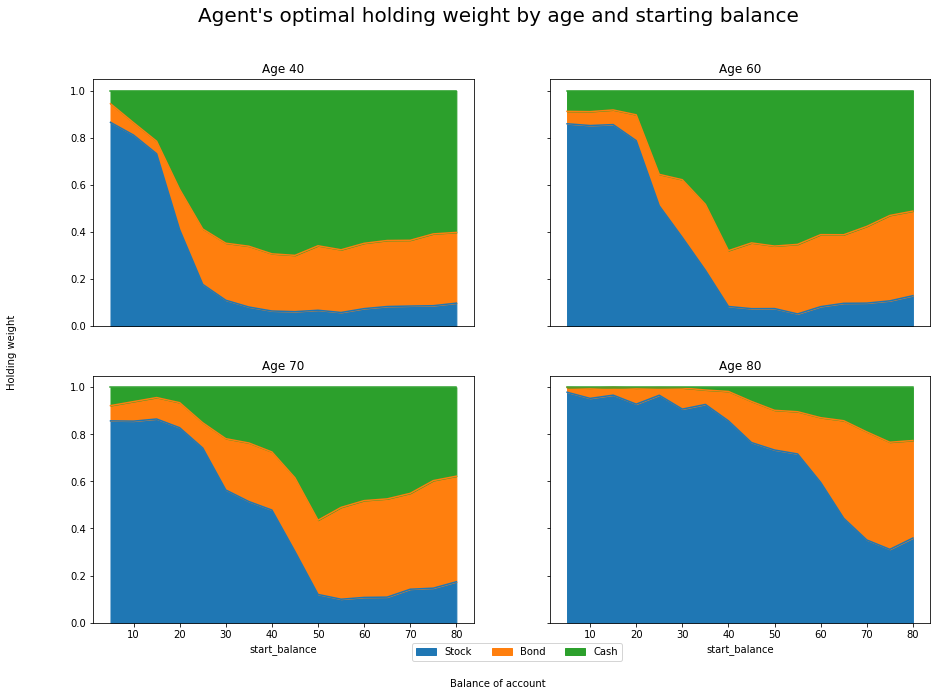

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True, sharey=True, figsize=(15,10))

temp_plot_df = hld_stats.loc[hld_stats.age==40][['start_balance','Stock','Bond','Cash']]
ax1 = temp_plot_df.plot.area(x = 'start_balance',ax=axes[0,0], legend=False,title = 'Age 40')
temp_plot_df1 = hld_stats.loc[hld_stats.age==60][['start_balance','Stock','Bond','Cash']]
ax2 = temp_plot_df1.plot.area(x = 'start_balance',ax=axes[0,1], legend=False,title = 'Age 60')
temp_plot_df2 = hld_stats.loc[hld_stats.age==70][['start_balance','Stock','Bond','Cash']]
temp_plot_df2.plot.area(x = 'start_balance',ax=axes[1,0], legend=False,title = 'Age 70')
temp_plot_df3 = hld_stats.loc[hld_stats.age==78][['start_balance','Stock','Bond','Cash']]
temp_plot_df3.plot.area(x = 'start_balance',ax=axes[1,1], legend=False,title = 'Age 80')

ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.44, 0.05), ncol=5 )

fig.text(0.5,0.04, "Balance of account", ha="center", va="center")
fig.text(0.05,0.5, "Holding weight", ha="center", va="center", rotation=90)
fig.suptitle("Agent's optimal holding weight by age and starting balance", fontsize=20)

In [ ]:
obs = env_simple.custom_reset(60,np.array([5.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

obs = env_simple.custom_reset(60,np.array([15.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

obs = env_simple.custom_reset(60,np.array([25.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

obs = env_simple.custom_reset(60,np.array([35.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

Observed Mkt Rtn:  ['0.14', '0.01', '0.01']
Age:61 Balance:5.00 Reward:0.00
Holding:  ['0.52', '0.48', '0.00']
Experienced Mkt Rtn:  ['0.13', '0.06', '0.01']

Observed Mkt Rtn:  ['-0.14', '-0.01', '0.01']
Age:61 Balance:15.00 Reward:0.00
Holding:  ['0.85', '0.15', '0.00']
Experienced Mkt Rtn:  ['-0.12', '0.04', '0.01']

Observed Mkt Rtn:  ['0.20', '0.07', '0.01']
Age:61 Balance:25.00 Reward:0.00
Holding:  ['0.50', '0.50', '0.00']
Experienced Mkt Rtn:  ['-0.18', '0.02', '0.01']

Observed Mkt Rtn:  ['0.09', '0.04', '0.01']
Age:61 Balance:35.00 Reward:-0.71
Holding:  ['0.38', '0.48', '0.13']
Experienced Mkt Rtn:  ['-0.20', '0.01', '0.01']



In [ ]:
obs = env_simple.custom_reset(70,np.array([5.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

obs = env_simple.custom_reset(70,np.array([15.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

obs = env_simple.custom_reset(70,np.array([25.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

obs = env_simple.custom_reset(70,np.array([35.0],dtype = np.float64))
print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
action, _states = model_custom.predict(obs)
obs, rewards, done, info = env_simple.step(np.array(action))
print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')

Observed Mkt Rtn:  ['0.12', '-0.01', '0.01']
Age:71 Balance:5.00 Reward:0.00
Holding:  ['0.50', '0.50', '0.00']
Experienced Mkt Rtn:  ['0.26', '-0.01', '0.01']

Observed Mkt Rtn:  ['0.18', '0.02', '0.01']
Age:71 Balance:15.00 Reward:0.11
Holding:  ['0.57', '0.43', '0.00']
Experienced Mkt Rtn:  ['0.15', '0.05', '0.01']

Observed Mkt Rtn:  ['0.02', '0.01', '0.01']
Age:71 Balance:25.00 Reward:0.00
Holding:  ['0.85', '0.15', '0.00']
Experienced Mkt Rtn:  ['-0.05', '0.06', '0.01']

Observed Mkt Rtn:  ['0.70', '0.10', '0.01']
Age:71 Balance:35.00 Reward:0.00
Holding:  ['0.01', '0.86', '0.13']
Experienced Mkt Rtn:  ['0.31', '0.05', '0.01']



In [ ]:
obs = env_simple.custom_reset(0,np.array([30.0],dtype = np.float64))
for i in range(11):
    action, _states = model_custom.predict(obs)
    print('Observed Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
    obs, rewards, done, info = env_simple.step(np.array(action))
    print(f"Age:{obs['age']} Balance:{obs['balance'][0]:.2f} Reward:{rewards:.2f}")
    print('Holding: ',["%.2f" % member for member in info['portfolio']])
    print('Experienced Mkt Rtn: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
    print('')

Observed Mkt Rtn:  ['0.19', '0.07', '0.01']
Age:71 Balance:30.00 Reward:0.00
Holding:  ['0.50', '0.50', '0.00']
Experienced Mkt Rtn:  ['0.03', '0.02', '0.01']

Observed Mkt Rtn:  ['0.03', '0.02', '0.01']
Age:72 Balance:30.66 Reward:0.00
Holding:  ['0.60', '0.40', '0.00']
Experienced Mkt Rtn:  ['0.18', '0.02', '0.01']

Observed Mkt Rtn:  ['0.18', '0.02', '0.01']
Age:73 Balance:34.35 Reward:0.00
Holding:  ['0.49', '0.49', '0.01']
Experienced Mkt Rtn:  ['0.46', '0.06', '0.01']

Observed Mkt Rtn:  ['0.46', '0.06', '0.01']
Age:74 Balance:43.20 Reward:0.00
Holding:  ['0.48', '0.52', '0.00']
Experienced Mkt Rtn:  ['0.07', '0.03', '0.01']

Observed Mkt Rtn:  ['0.07', '0.03', '0.01']
Age:75 Balance:45.24 Reward:0.00
Holding:  ['0.00', '1.00', '0.00']
Experienced Mkt Rtn:  ['0.26', '0.09', '0.01']

Observed Mkt Rtn:  ['0.26', '0.09', '0.01']
Age:76 Balance:49.19 Reward:0.00
Holding:  ['0.29', '0.71', '0.00']
Experienced Mkt Rtn:  ['0.21', '0.04', '0.01']

Observed Mkt Rtn:  ['0.21', '0.04', '0.0

Experiment B: Financial market intuition.
Assume 4 market regime change (full environment) and 3 investment assets, train an agent with:
1. Generated 252 by 3 return matrix
2. Mean and Std of 3 asset classes
3. Directly give the state

Test agent's reaction in different market regime

In [ ]:
import random
class AssetAllocationEnvironment2(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']} ## This means the print out will be in a fashion for human read

    def __init__(self,reward_type='sharpe'): #Choose between goal and sharpe
        super(AssetAllocationEnvironment2, self).__init__()

        self.market_cycle = random.randint(0, 3) # current market cycle
        self.reward_range = (0, 100) #Doesn't seem necessary

        # initialize market behavior
        self.us_equity_mean = 0 # US equity mean return
        self.us_equity_std = 0 # US equity standard deviation
        self.euro_equity_mean = 0 # euro equity mean return
        self.euro_equity_std = 0 # euro equity standard deviation
        self.em_equity_mean = 0 # emerging markets mean return
        self.em_equity_std = 0 # emerging markets standard deviation
        self.treasury_bond_mean = 0 # treasury bond mean return
        self.treasury_bond_std = 0 # treasury bond standard deviation
        self.corporate_bond_mean = 0 # corporate bond mean return
        self.corporate_bond_std = 0 # corporate bond standard deviation
        self.gold_mean = 0 # gold mean return
        self.gold_std = 0 # gold standard deviation
        self.state1_cash_mean = 0.005 # cash has 0.5% mean return
        self.state1_cash_sd = 0.0 # cash has 0% standard deviation

        # set mean and std of different assets based on  current market cycle
        self._get_market_behavior()

        self.annual_trading_days = 252 # 252 traading days per year
        self.current_step = np.random.normal(0,1,(252,7))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.us_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.euro_equity_mean/self.annual_trading_days + self.current_step[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.em_equity_mean/self.annual_trading_days + self.current_step[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,3] = self.treasury_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,4] = self.corporate_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,5] = self.gold_mean/self.annual_trading_days + self.current_step[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,6] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 40 # start at 40 years old
        self.reward_type = reward_type #Choose between goal and sharpe
        self.goal = 10 #reach 99 MV or more
        self.balance = np.array([1.0],dtype = np.float64) #start with 1 in MV
        self.benchmark_balance = self.balance
        self.port_weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]) # start with all cash portfolio

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = gym.spaces.Box( #continous action space
          low=np.array([0, 0, 0, 0, 0, 0, 0]), high=np.array([1, 1, 1, 1, 1, 1, 1]), dtype=np.float16)
        #US equety Stock, euro equity stock, emergine market equity stock, treasury bond, corporate bond, Gold, Cash

        spaces = {
            'market': gym.spaces.Box(low=-1, high=1, shape=(252,7), dtype=np.float16), #252 trading days and 7 instruments. with daily returns
            'balance': gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float64),
        }
        self.observation_space = gym.spaces.Dict(spaces)

    def _next_observation(self, observed_market_regime=None):
        # This is the function that generates the state output

        self._get_market_behavior(observed_market_regime) # determine market behavior

        return_sim = np.random.normal(0,1,(252,7))#Stock, Bond, Cash
        return_sim[:,0] = self.us_equity_mean/self.annual_trading_days + return_sim[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        return_sim[:,1] = self.euro_equity_mean/self.annual_trading_days + return_sim[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        return_sim[:,2] = self.em_equity_mean/self.annual_trading_days + return_sim[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        return_sim[:,3] = self.treasury_bond_mean/self.annual_trading_days + return_sim[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        return_sim[:,4] = self.corporate_bond_mean/self.annual_trading_days + return_sim[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        return_sim[:,5] = self.gold_mean/self.annual_trading_days + return_sim[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        return_sim[:,6] = self.state1_cash_mean/self.annual_trading_days + return_sim[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))
        self.current_step = return_sim

        # Append additional data and scale each value to between 0-1
        obs = {
            'market':return_sim,
            'balance':self.balance
        }

        return obs

    def _take_action(self, action):
        # Update class variables based on the actions taken by agent
        self.port_weights = action #Action space is Portfolio allocation
        # If we consider transaction cost or tax, should implement here

    def _portfolio_softmax(self, x):
        # Softmax function to set the portfolio weights according to constraints
        if x.sum()<=0:
            x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
        else:
            x = x / x.sum()

        return x

    def step(self, action):
        # Execute one time step within the environment
        benchmark_portfolio = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.16])

        temp_old_market_cycle = self.market_cycle
        self._take_action(self._portfolio_softmax(action)) # allocate portfolio weights based on action by agent
        obs = self._next_observation() # determine next market state

        self.age += 1 #age increase

        temp_return = np.sum((self.current_step.sum(axis=0)+1)*self.port_weights)
        temp_benchmark_return = np.sum((self.current_step.sum(axis=0)+1)*benchmark_portfolio)
        self.balance = self.balance * temp_return  #market value update
        self.benchmark_balance = self.benchmark_balance * temp_benchmark_return
        # reward assignment
        if self.reward_type == 'goal':
            if self.age >= 80: #assume 80 year old is the end of the simulation, or can change to faterlity table
                done = True
                if self.balance >= self.goal: #only one type of reward for reaching the goal
                    reward = 100.0
                else:
                    reward = 0.0
            else:
                done = False
                if temp_return > 0: #remove, unnecessary
                    reward = 0.0#0.1 * temp_return
                else:
                    reward = 0.0#-0.1 * temp_return
        else:
            if self.age >= 80: #assume 80 year old is the end of the simulation, or can change to faterlity table
                done = True
            else:
                done = False
            #Beat a simple strategy
            temp_sd = np.std((self.current_step*self.port_weights).sum(axis=1) - (self.current_step*benchmark_portfolio).sum(axis=1))
            temp_rtn = np.mean((self.current_step*self.port_weights).sum(axis=1)-(self.current_step*benchmark_portfolio).sum(axis=1))
            if temp_sd > 0.0000001:
                temp_sharpe = temp_rtn / temp_sd
            else:
                temp_sharpe = 0.0 #all cash portfolio

            reward = temp_sharpe


        return obs, reward, done, {'balances':[self.balance,self.benchmark_balance],'portfolio':self.port_weights,'market_state':self.market_cycle,'last_market_state':temp_old_market_cycle}

    def reset(self):
        self.market_cycle = random.randint(0, 3) # current market cycle
        # Reset the state of the environment to an initial state
        self.current_step = np.random.normal(0,1,(252,7))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.us_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.euro_equity_mean/self.annual_trading_days + self.current_step[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.em_equity_mean/self.annual_trading_days + self.current_step[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,3] = self.treasury_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,4] = self.corporate_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,5] = self.gold_mean/self.annual_trading_days + self.current_step[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,6] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 40 # start at 40 years old
        self.goal = 10 #reach 100 MV or more
        self.balance = np.array([1.0],dtype = np.float64) #start with 50 in MV
        self.benchmark_balance = self.balance
        self.port_weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]) # start with all cash portfolio

        return self._next_observation()

    def render(self, mode='human', close=False):
        print(f'Current Step: {self.current_step.shape}')
        print(f'Balance: {self.balance}')
        print(f'Age: {self.age}')
        print(f'Position: {self.port_weights}')
        print(f'Market State: {self.market_cycle}')

    def custom_reset(self,observed_market_regime = 0):
        self.market_cycle = observed_market_regime
        # Reset the state of the environment to an initial state
        self.current_step = np.random.normal(0,1,(252,7))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.us_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.euro_equity_mean/self.annual_trading_days + self.current_step[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.em_equity_mean/self.annual_trading_days + self.current_step[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,3] = self.treasury_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,4] = self.corporate_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,5] = self.gold_mean/self.annual_trading_days + self.current_step[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,6] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 40 # start at 40 years old
        self.goal = 10 #reach 100 MV or more
        self.balance = np.array([1.0],dtype = np.float64) #start with 50 in MV
        self.benchmark_balance = self.balance
        self.port_weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]) # start with all cash portfolio

        return self._next_observation(observed_market_regime)

    def _get_market_behavior(self, observed_market_regime = None):
        # market cycle info:
        #    0 = Recovery,
        #    1 = Development
        #    2 = Mature
        #    3 = Crisis

        if observed_market_regime is None:
            proba = random.randint(1, 10)
            # determine market state after probability of transition
            if self.market_cycle == 0:
                if proba > 4: # Transition to Development
                    self.market_cycle = 1
            elif self.market_cycle == 1:
                if proba <= 4: # Transition to Mature
                    self.market_cycle = 2
            elif self.market_cycle == 2:
                if proba <= 3: # Transition to Crisis
                    self.market_cycle = 3
            elif self.market_cycle == 3:
                if proba > 2: # Transition to recovery
                    self.market_cycle = 0
        else:
            self.market_cycle = observed_market_regime

        # determine market behavior
        if self.market_cycle == 0:
            self.us_equity_mean = 0.15
            self.us_equity_std = 0.20
            self.euro_equity_mean = 0.10
            self.euro_equity_std = 0.20
            self.em_equity_mean = 0.25
            self.em_equity_std = 0.30
            self.treasury_bond_mean = -0.01
            self.treasury_bond_std = 0.02
            self.corporate_bond_mean = 0.05
            self.corporate_bond_std = 0.07
            self.gold_mean = -0.10
            self.gold_std = 0.15
        elif self.market_cycle == 1:
            self.us_equity_mean = 0.12
            self.us_equity_std = 0.15
            self.euro_equity_mean = 0.08
            self.euro_equity_std = 0.12
            self.em_equity_mean = 0.20
            self.em_equity_std = 0.20
            self.treasury_bond_mean = 0.01
            self.treasury_bond_std = 0.02
            self.corporate_bond_mean = 0.03
            self.corporate_bond_std = 0.05
            self.gold_mean = 0.01
            self.gold_std = 0.02
        elif self.market_cycle == 2:
            self.us_equity_mean = 0.06
            self.us_equity_std = 0.10
            self.euro_equity_mean = 0.08
            self.euro_equity_std = 0.10
            self.em_equity_mean = 0.10
            self.em_equity_std = 0.20
            self.treasury_bond_mean = 0.01
            self.treasury_bond_std = 0.02
            self.corporate_bond_mean = 0.03
            self.corporate_bond_std = 0.06
            self.gold_mean = -0.02
            self.gold_std = 0.02
        elif self.market_cycle == 3:
            self.us_equity_mean = -0.20
            self.us_equity_std = 0.30
            self.euro_equity_mean = -0.20
            self.euro_equity_std = 0.30
            self.em_equity_mean = -0.40
            self.em_equity_std = 0.50
            self.treasury_bond_mean = 0.10
            self.treasury_bond_std = 0.05
            self.corporate_bond_mean = -0.10
            self.corporate_bond_std = 0.20
            self.gold_mean = 0.20
            self.gold_std = 0.15

In [ ]:
env = DummyVecEnv([lambda: AssetAllocationEnvironment2()])

/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
from stable_baselines3.common.env_checker import check_env
env_simple = AssetAllocationEnvironment2() #not vectorize
check_env(env_simple)

/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your observation market has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  f"Your observation {key} has an unconventional shape (neither an image, nor a 1D vector). "
/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:273: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [ ]:
import gym
import torch as th
from torch import nn

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, market_features_dim1: int = 128, market_features_dim2: int = 32):
        super(CustomCombinedExtractor, self).__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        # We need to know size of the output of this extractor,
        # so go over all the spaces and compute output feature sizes
        for key, subspace in observation_space.spaces.items():
            if key == "market":
                extractors[key] = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(252*7,market_features_dim1), #input size, 252*7
                    nn.Linear(market_features_dim1,market_features_dim2),
                    nn.ReLU(),
                    nn.Linear(market_features_dim2,market_features_dim2),
                    nn.Linear(market_features_dim2,4),
                    nn.Softmax(),
                )
                total_concat_size += 4
            elif key == "balance":
                # Just append
                extractors[key] = nn.Flatten()
                total_concat_size += 1

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            encoded_tensor_list.append(extractor(observations[key]))

        return th.cat(encoded_tensor_list, dim=1)

In [ ]:
policy_kwargs = dict(
    net_arch=[128, dict(vf=[128,32], pi=[32,16])], #This changes the  neural network design for actor and critic network. This is after the feature extractor.
    features_extractor_class=CustomCombinedExtractor,
    features_extractor_kwargs=dict(market_features_dim1=32,market_features_dim2=8),
)
model_custom = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=0)

In [ ]:
model_custom.learn(total_timesteps=300000)

/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
# Evaluate the trained agent
eval_env = DummyVecEnv([lambda: AssetAllocationEnvironment2()])
mean_reward, std_reward = evaluate_policy(model_custom, eval_env, n_eval_episodes=200)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:1.92 +/- 0.49


In [ ]:
obs = env.reset()
market_cycle_map = {
    0: 'Recovery',
    1: 'Development',
    2: 'Mature',
    3: 'Crisis',
}
asset_class_list = ['US Eq','Euro Eq','EM Eq','Treasury','Corporate','Gold','Cash']
for i in range(41):
    action, _states = model_custom.predict(obs)
    print('Observed Market: ',["%.2f" % member for member in obs['market'][0].sum(axis=0)])
    obs, rewards, done, info = env.step(action)
    print(f"Observed Market Cycle: {market_cycle_map[info[0]['last_market_state']]} | Current Market Cycle: {market_cycle_map[info[0]['market_state']]} | Reward:{rewards[0]:.2f}")
    print('Investment:',asset_class_list)
    print('Holding: ',["%.2f" % member for member in info[0]['portfolio']])
    print('Experienced Market: ',["%.2f" % member for member in obs['market'][0].sum(axis=0)])
    print('')

Observed Market:  ['-0.28', '-0.13', '-0.36', '0.10', '-0.10', '0.20', '0.00']
Observed Market Cycle: Crisis | Current Market Cycle: Recovery | Reward:0.91
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.17', '0.17', '0.17', '0.17', '0.17', '0.00', '0.17']
Experienced Market:  ['0.16', '0.04', '0.37', '-0.01', '0.05', '-0.10', '0.00']

Observed Market:  ['0.16', '0.04', '0.37', '-0.01', '0.05', '-0.10', '0.00']
Observed Market Cycle: Recovery | Current Market Cycle: Development | Reward:0.38
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.20', '0.20', '0.20', '0.20', '0.20', '0.00', '0.00']
Experienced Market:  ['0.06', '0.06', '0.23', '0.01', '0.03', '0.01', '0.00']

Observed Market:  ['0.06', '0.06', '0.23', '0.01', '0.03', '0.01', '0.00']
Observed Market Cycle: Development | Current Market Cycle: Mature | Reward:0.44
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Go

In [ ]:
temp_portfolio = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
benchmark_portfolio = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.16])
total_n = 100
temp_mkt_cycle = 0
temp_reward = 0
for i in range(total_n):
    obs = env_simple.custom_reset(temp_mkt_cycle)
    action, _states = model_custom.predict(obs)
    obs, rewards, done, info = env_simple.step(action)
    temp_portfolio = temp_portfolio + info['portfolio']/total_n
    temp_reward = temp_reward + rewards/total_n

print(f'When Observed: {market_cycle_map[temp_mkt_cycle]}. Agent has average reward of {temp_reward:.2f} and will choose to hold:')
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in temp_portfolio])




When Observed: Recovery. Agent has average reward of 0.52 and will choose to hold:
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.21', '0.21', '0.21', '0.12', '0.20', '0.00', '0.05']


In [ ]:
temp_portfolio1 = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
benchmark_portfolio = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.16])
total_n = 100
temp_mkt_cycle = 1
temp_reward = 0
for i in range(total_n):
    obs = env_simple.custom_reset(temp_mkt_cycle)
    action, _states = model_custom.predict(obs)
    obs, rewards, done, info = env_simple.step(action)
    temp_portfolio1 = temp_portfolio1 + info['portfolio']/total_n
    temp_reward = temp_reward + rewards/total_n

print(f'When Observed: {market_cycle_map[temp_mkt_cycle]}. Agent has average reward of {temp_reward:.2f} and will choose to hold:')
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in temp_portfolio1])

When Observed: Development. Agent has average reward of 0.43 and will choose to hold:
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.21', '0.21', '0.21', '0.12', '0.21', '0.00', '0.05']


In [ ]:
temp_portfolio2 = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
benchmark_portfolio = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.16])
total_n = 100
temp_mkt_cycle = 2
temp_reward = 0
for i in range(total_n):
    obs = env_simple.custom_reset(temp_mkt_cycle)
    action, _states = model_custom.predict(obs)
    obs, rewards, done, info = env_simple.step(action)
    temp_portfolio2 = temp_portfolio2 + info['portfolio']/total_n
    temp_reward = temp_reward + rewards/total_n

print(f'When Observed: {market_cycle_map[temp_mkt_cycle]}. Agent has average reward of {temp_reward:.2f} and will choose to hold:')
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in temp_portfolio2])

When Observed: Mature. Agent has average reward of 0.05 and will choose to hold:
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.21', '0.21', '0.20', '0.12', '0.20', '0.00', '0.06']


In [ ]:
temp_portfolio3 = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
benchmark_portfolio = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.16])
total_n = 100
temp_mkt_cycle = 3
temp_reward = 0
for i in range(total_n):
    obs = env_simple.custom_reset(temp_mkt_cycle)
    action, _states = model_custom.predict(obs)
    obs, rewards, done, info = env_simple.step(action)
    temp_portfolio3 = temp_portfolio3 + info['portfolio']/total_n
    temp_reward = temp_reward + rewards/total_n

print(f'When Observed: {market_cycle_map[temp_mkt_cycle]}. Agent has average reward of {temp_reward:.2f} and will choose to hold:')
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in temp_portfolio3])

When Observed: Crisis. Agent has average reward of 0.40 and will choose to hold:
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.20', '0.20', '0.20', '0.13', '0.20', '0.00', '0.07']


Text(0.5, 0.98, "Agent's optimal holding weight given different market regime")

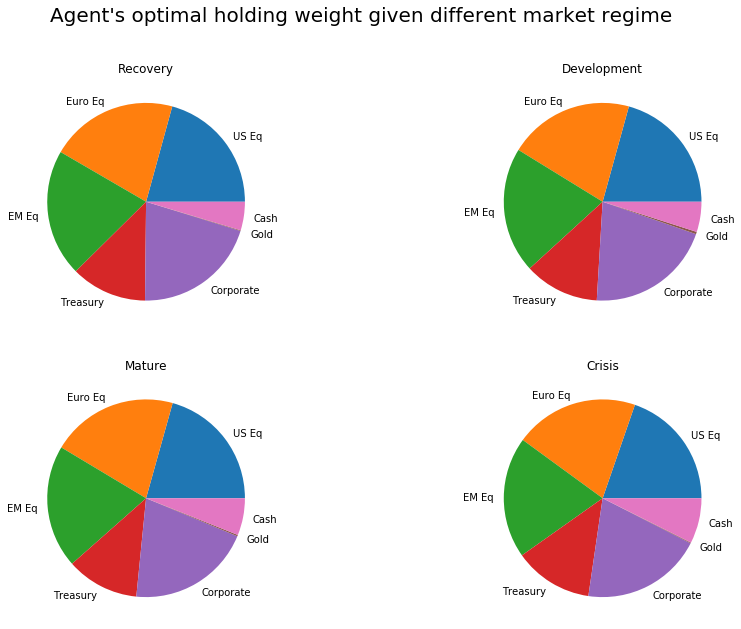

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,sharex=True, sharey=True, figsize=(15,10))

axs[0, 0].pie(temp_portfolio, labels = asset_class_list)
axs[0, 0].set_title('Recovery')
axs[0, 1].pie(temp_portfolio1, labels = asset_class_list)
axs[0, 1].set_title('Development')
axs[1, 0].pie(temp_portfolio2, labels = asset_class_list)
axs[1, 0].set_title('Mature')
axs[1, 1].pie(temp_portfolio3, labels = asset_class_list)
axs[1, 1].set_title('Crisis')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Agent's optimal holding weight given different market regime", fontsize=20)



In [ ]:
obs = env_simple.custom_reset(1)
action, _states = model_custom.predict(obs)
print('Observed Market: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
obs, rewards, done, info = env_simple.step(action)
print(f"Observed Market Cycle: {market_cycle_map[info['last_market_state']]} | Current Market Cycle: {market_cycle_map[info['market_state']]} | Reward:{rewards:.2f}")
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Market: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')


Observed Market:  ['0.13', '0.05', '0.12', '0.01', '0.03', '0.01', '0.01']
Observed Market Cycle: Development | Current Market Cycle: Development | Reward:0.33
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.20', '0.20', '0.20', '0.20', '0.20', '0.00', '0.00']
Experienced Market:  ['0.11', '0.02', '0.15', '0.01', '0.03', '0.01', '0.01']



In [ ]:
obs = env_simple.custom_reset(2)
action, _states = model_custom.predict(obs)
print('Observed Market: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
obs, rewards, done, info = env_simple.step(action)
print(f"Observed Market Cycle: {market_cycle_map[info['last_market_state']]} | Current Market Cycle: {market_cycle_map[info['market_state']]} | Reward:{rewards:.2f}")
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Market: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')


Observed Market:  ['0.07', '0.07', '0.05', '0.01', '0.03', '-0.02', '0.01']
Observed Market Cycle: Mature | Current Market Cycle: Mature | Reward:0.37
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.20', '0.20', '0.20', '0.20', '0.20', '0.00', '0.00']
Experienced Market:  ['0.06', '0.06', '0.09', '0.01', '0.03', '-0.02', '0.01']



In [ ]:
obs = env_simple.custom_reset(3)
action, _states = model_custom.predict(obs)
print('Observed Market: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
obs, rewards, done, info = env_simple.step(action)
print(f"Observed Market Cycle: {market_cycle_map[info['last_market_state']]} | Current Market Cycle: {market_cycle_map[info['market_state']]} | Reward:{rewards:.2f}")
print('Investment:',asset_class_list)
print('Holding: ',["%.2f" % member for member in info['portfolio']])
print('Experienced Market: ',["%.2f" % member for member in obs['market'].sum(axis=0)])
print('')


Observed Market:  ['-0.30', '-0.22', '-0.38', '0.10', '-0.10', '0.20', '0.01']
Observed Market Cycle: Crisis | Current Market Cycle: Recovery | Reward:0.46
Investment: ['US Eq', 'Euro Eq', 'EM Eq', 'Treasury', 'Corporate', 'Gold', 'Cash']
Holding:  ['0.20', '0.20', '0.20', '0.20', '0.20', '0.00', '0.00']
Experienced Market:  ['0.10', '0.06', '0.15', '-0.01', '0.05', '-0.10', '0.01']



In [ ]:
obs = env_simple.custom_reset(0)
market_cycle_map = {
    0: 'Recovery',
    1: 'Development',
    2: 'Mature',
    3: 'Crisis',
}
balance_over_days = []
benchmark_balance_over_days = []
asset_class_list = ['US Eq','Euro Eq','EM Eq','Treasury','Corporate','Gold','Cash']
for i in range(40):
    action, _states = model_custom.predict(obs)
    obs, rewards, done, info = env_simple.step(action)
    balance_over_days = np.append(balance_over_days,info['balances'][0])
    benchmark_balance_over_days = np.append(benchmark_balance_over_days,info['balances'][1])



/Users/yantao/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


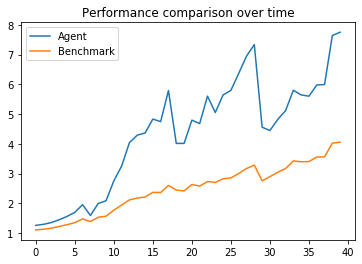

In [ ]:
plt.plot(balance_over_days, label = "Agent")
plt.plot(benchmark_balance_over_days, label = "Benchmark")
plt.title('Performance comparison over time')
plt.legend()
plt.show()


Give the state directly

In [ ]:
import random
class AssetAllocationEnvironment3(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']} ## This means the print out will be in a fashion for human read

    def __init__(self,reward_type='sharpe'): #Choose between goal and sharpe
        super(AssetAllocationEnvironment3, self).__init__()

        self.market_cycle = random.randint(0, 3) # current market cycle
        self.reward_range = (0, 100) #Doesn't seem necessary

        # initialize market behavior
        self.us_equity_mean = 0 # US equity mean return
        self.us_equity_std = 0 # US equity standard deviation
        self.euro_equity_mean = 0 # euro equity mean return
        self.euro_equity_std = 0 # euro equity standard deviation
        self.em_equity_mean = 0 # emerging markets mean return
        self.em_equity_std = 0 # emerging markets standard deviation
        self.treasury_bond_mean = 0 # treasury bond mean return
        self.treasury_bond_std = 0 # treasury bond standard deviation
        self.corporate_bond_mean = 0 # corporate bond mean return
        self.corporate_bond_std = 0 # corporate bond standard deviation
        self.gold_mean = 0 # gold mean return
        self.gold_std = 0 # gold standard deviation
        self.state1_cash_mean = 0.005 # cash has 0.5% mean return
        self.state1_cash_sd = 0.0 # cash has 0% standard deviation

        # set mean and std of different assets based on  current market cycle
        self._get_market_behavior()

        self.annual_trading_days = 252 # 252 traading days per year
        self.current_step = np.random.normal(0,1,(252,7))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.us_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.euro_equity_mean/self.annual_trading_days + self.current_step[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.em_equity_mean/self.annual_trading_days + self.current_step[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,3] = self.treasury_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,4] = self.corporate_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,5] = self.gold_mean/self.annual_trading_days + self.current_step[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,6] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 40 # start at 40 years old
        self.reward_type = reward_type #Choose between goal and sharpe
        self.goal = 10 #reach 99 MV or more
        self.balance = np.array([1.0],dtype = np.float64) #start with 1 in MV
        self.port_weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]) # start with all cash portfolio

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = gym.spaces.Box( #continous action space
          low=np.array([0, 0, 0, 0, 0, 0, 0]), high=np.array([1, 1, 1, 1, 1, 1, 1]), dtype=np.float16)
        #US equety Stock, euro equity stock, emergine market equity stock, treasury bond, corporate bond, Gold, Cash
        self.observation_space = gym.spaces.Discrete(4)

    def _next_observation(self):
        # This is the function that generates the state output

        self._get_market_behavior() # determine market behavior

        return_sim = np.random.normal(0,1,(252,7))#Stock, Bond, Cash
        return_sim[:,0] = self.us_equity_mean/self.annual_trading_days + return_sim[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        return_sim[:,1] = self.euro_equity_mean/self.annual_trading_days + return_sim[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        return_sim[:,2] = self.em_equity_mean/self.annual_trading_days + return_sim[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        return_sim[:,3] = self.treasury_bond_mean/self.annual_trading_days + return_sim[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        return_sim[:,4] = self.corporate_bond_mean/self.annual_trading_days + return_sim[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        return_sim[:,5] = self.gold_mean/self.annual_trading_days + return_sim[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        return_sim[:,6] = self.state1_cash_mean/self.annual_trading_days + return_sim[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))
        self.current_step = return_sim

        # Append additional data and scale each value to between 0-1
        obs = self.market_cycle

        return obs

    def _take_action(self, action):
        # Update class variables based on the actions taken by agent
        self.port_weights = action #Action space is Portfolio allocation
        # If we consider transaction cost or tax, should implement here

    def _portfolio_softmax(self, x):
        # Softmax function to set the portfolio weights according to constraints
        if x.sum()<=0:
            x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
        else:
            x = x / x.sum()

        return x

    def step(self, action):
        # Execute one time step within the environment
        temp_old_market_cycle = self.market_cycle
        self._take_action(self._portfolio_softmax(action)) # allocate portfolio weights based on action by agent
        obs = self._next_observation() # determine next market state

        self.age += 1 #age increase

        temp_return = np.sum((self.current_step.sum(axis=0)+1)*self.port_weights)

        self.balance = self.balance * temp_return  #market value update

        # reward assignment
        if self.reward_type == 'goal':
            if self.age >= 80: #assume 80 year old is the end of the simulation, or can change to faterlity table
                done = True
                if self.balance >= self.goal: #only one type of reward for reaching the goal
                    reward = 100.0
                else:
                    reward = 0.0
            else:
                done = False
                if temp_return > 0: #remove, unnecessary
                    reward = 0.0#0.1 * temp_return
                else:
                    reward = 0.0#-0.1 * temp_return
        else:
            if self.age >= 80: #assume 80 year old is the end of the simulation, or can change to faterlity table
                done = True
            else:
                done = False
            #Beat a sunoke strategy
            benchmark_portfolio = np.array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.16])
            temp_sd = np.std((self.current_step*self.port_weights).sum(axis=1) - (self.current_step*benchmark_portfolio).sum(axis=1))
            temp_rtn = np.mean((self.current_step*self.port_weights).sum(axis=1)-(self.current_step*benchmark_portfolio).sum(axis=1))
            if temp_sd > 0.0000001:
                temp_sharpe = temp_rtn / temp_sd
            else:
                temp_sharpe = 0.0 #all cash portfolio

            reward = temp_sharpe


        return obs, reward, done, {'portfolio':self.port_weights,'market_state':self.market_cycle,'last_market_state':temp_old_market_cycle}

    def reset(self):
        self.market_cycle = random.randint(0, 3) # current market cycle
        # Reset the state of the environment to an initial state
        self.current_step = np.random.normal(0,1,(252,7))# store the current step return matrix, random initialize
        self.current_step[:,0] = self.us_equity_mean/self.annual_trading_days + self.current_step[:,0] * (self.us_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,1] = self.euro_equity_mean/self.annual_trading_days + self.current_step[:,1] * (self.euro_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,2] = self.em_equity_mean/self.annual_trading_days + self.current_step[:,2] * (self.em_equity_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,3] = self.treasury_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.treasury_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,4] = self.corporate_bond_mean/self.annual_trading_days + self.current_step[:,2] * (self.corporate_bond_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,5] = self.gold_mean/self.annual_trading_days + self.current_step[:,2] * (self.gold_std/np.sqrt(self.annual_trading_days))
        self.current_step[:,6] = self.state1_cash_mean/self.annual_trading_days + self.current_step[:,2] * (self.state1_cash_sd/np.sqrt(self.annual_trading_days))

        self.age = 40 # start at 40 years old
        self.goal = 10 #reach 100 MV or more
        self.balance = np.array([1.0],dtype = np.float64) #start with 50 in MV
        self.port_weights = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]) # start with all cash portfolio

        return self._next_observation()

    def render(self, mode='human', close=False):
        print(f'Current Step: {self.current_step.shape}')
        print(f'Balance: {self.balance}')
        print(f'Age: {self.age}')
        print(f'Position: {self.port_weights}')
        print(f'Market State: {self.market_cycle}')

    def _get_market_behavior(self):
        # market cycle info:
        #    0 = Recovery,
        #    1 = Development
        #    2 = Mature
        #    3 = Crisis

        proba = random.randint(1, 10)
        # determine market state after probability of transition
        if self.market_cycle == 0:
            if proba > 4: # Transition to Development
                self.market_cycle = 1
        elif self.market_cycle == 1:
            if proba <= 4: # Transition to Mature
                self.market_cycle = 2
        elif self.market_cycle == 2:
            if proba <= 3: # Transition to Crisis
                self.market_cycle = 3
        elif self.market_cycle == 3:
            if proba > 2: # Transition to recovery
                self.market_cycle = 0
        # determine market behavior
        if self.market_cycle == 0:
            self.us_equity_mean = 0.15
            self.us_equity_std = 0.20
            self.euro_equity_mean = 0.10
            self.euro_equity_std = 0.20
            self.em_equity_mean = 0.25
            self.em_equity_std = 0.30
            self.treasury_bond_mean = -0.01
            self.treasury_bond_std = 0.02
            self.corporate_bond_mean = 0.05
            self.corporate_bond_std = 0.07
            self.gold_mean = -0.10
            self.gold_std = 0.15
        elif self.market_cycle == 1:
            self.us_equity_mean = 0.12
            self.us_equity_std = 0.15
            self.euro_equity_mean = 0.08
            self.euro_equity_std = 0.12
            self.em_equity_mean = 0.20
            self.em_equity_std = 0.20
            self.treasury_bond_mean = 0.01
            self.treasury_bond_std = 0.02
            self.corporate_bond_mean = 0.03
            self.corporate_bond_std = 0.05
            self.gold_mean = 0.01
            self.gold_std = 0.02
        elif self.market_cycle == 2:
            self.us_equity_mean = 0.06
            self.us_equity_std = 0.10
            self.euro_equity_mean = 0.08
            self.euro_equity_std = 0.10
            self.em_equity_mean = 0.10
            self.em_equity_std = 0.20
            self.treasury_bond_mean = 0.01
            self.treasury_bond_std = 0.02
            self.corporate_bond_mean = 0.03
            self.corporate_bond_std = 0.06
            self.gold_mean = -0.02
            self.gold_std = 0.02
        elif self.market_cycle == 3:
            self.us_equity_mean = -0.20
            self.us_equity_std = 0.30
            self.euro_equity_mean = -0.20
            self.euro_equity_std = 0.30
            self.em_equity_mean = -0.40
            self.em_equity_std = 0.50
            self.treasury_bond_mean = 0.10
            self.treasury_bond_std = 0.05
            self.corporate_bond_mean = -0.10
            self.corporate_bond_std = 0.20
            self.gold_mean = 0.20
            self.gold_std = 0.15

In [ ]:
env3 = AssetAllocationEnvironment3() #not vectorize
check_env(env3)

In [ ]:
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[32, 32], vf=[32, 32])])
# Create the agent
model3 = PPO("MlpPolicy", env3, policy_kwargs=policy_kwargs, verbose=1)
model3.learn(total_timesteps=300000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | -0.278   |
| time/              |          |
|    fps             | 1443     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | -0.239      |
| time/                   |             |
|    fps                  | 1225        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009366142 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 0.817       |
| time/                   |             |
|    fps                  | 1092        |
|    iterations           | 11          |
|    time_elapsed         | 20          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.008654177 |
|    clip_fraction        | 0.087       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.74       |
|    explained_variance   | 0.00518     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0416      |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0105     |
|    std                  | 0.97        |
|    value_loss           | 0.0589      |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 40           |
|    ep_rew_mean          | 1.18         |
| time/                   |              |
|    fps                  | 1080         |
|    iterations           | 20           |
|    time_elapsed         | 37           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0076040826 |
|    clip_fraction        | 0.0792       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.61        |
|    explained_variance   | 0.0142       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0341       |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00947     |
|    std                  | 0.957        |
|    value_loss           | 0.11         |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.4         |
| time/                   |             |
|    fps                  | 1075        |
|    iterations           | 29          |
|    time_elapsed         | 55          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.007558844 |
|    clip_fraction        | 0.079       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.31       |
|    explained_variance   | 0.00954     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.05        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00804    |
|    std                  | 0.917       |
|    value_loss           | 0.13        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.46        |
| time/                   |             |
|    fps                  | 1073        |
|    iterations           | 38          |
|    time_elapsed         | 72          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.008063542 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.24       |
|    explained_variance   | 0.00936     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0545      |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00748    |
|    std                  | 0.905       |
|    value_loss           | 0.145       |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.63        |
| time/                   |             |
|    fps                  | 1072        |
|    iterations           | 47          |
|    time_elapsed         | 89          |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.008474515 |
|    clip_fraction        | 0.0711      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.08       |
|    explained_variance   | 0.0115      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0788      |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00638    |
|    std                  | 0.887       |
|    value_loss           | 0.157       |
-----------------------------------------
----------------------------------------
| rollout/                |        

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 40         |
|    ep_rew_mean          | 1.67       |
| time/                   |            |
|    fps                  | 1069       |
|    iterations           | 56         |
|    time_elapsed         | 107        |
|    total_timesteps      | 114688     |
| train/                  |            |
|    approx_kl            | 0.00682929 |
|    clip_fraction        | 0.0758     |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.07      |
|    explained_variance   | 0.00778    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0823     |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.00781   |
|    std                  | 0.888      |
|    value_loss           | 0.174      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.63        |
| time/                   |             |
|    fps                  | 1069        |
|    iterations           | 65          |
|    time_elapsed         | 124         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.007356187 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.07       |
|    explained_variance   | 0.00883     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0707      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00559    |
|    std                  | 0.891       |
|    value_loss           | 0.165       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.89        |
| time/                   |             |
|    fps                  | 1068        |
|    iterations           | 74          |
|    time_elapsed         | 141         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.008491296 |
|    clip_fraction        | 0.0789      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.72       |
|    explained_variance   | 0.0183      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00774    |
|    std                  | 0.845       |
|    value_loss           | 0.203       |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.86        |
| time/                   |             |
|    fps                  | 1068        |
|    iterations           | 83          |
|    time_elapsed         | 159         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.007085886 |
|    clip_fraction        | 0.055       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.56       |
|    explained_variance   | 0.0129      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.1         |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0036     |
|    std                  | 0.83        |
|    value_loss           | 0.193       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.9         |
| time/                   |             |
|    fps                  | 1067        |
|    iterations           | 92          |
|    time_elapsed         | 176         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.008601027 |
|    clip_fraction        | 0.0915      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.4        |
|    explained_variance   | 0.019       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0547      |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00773    |
|    std                  | 0.812       |
|    value_loss           | 0.208       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 40        |
|    ep_rew_mean          | 1.91      |
| time/                   |           |
|    fps                  | 1067      |
|    iterations           | 101       |
|    time_elapsed         | 193       |
|    total_timesteps      | 206848    |
| train/                  |           |
|    approx_kl            | 0.0085731 |
|    clip_fraction        | 0.0639    |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.24     |
|    explained_variance   | 0.0141    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0756    |
|    n_updates            | 1000      |
|    policy_gradient_loss | -0.00624  |
|    std                  | 0.795     |
|    value_loss           | 0.221     |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.92        |
| time/                   |             |
|    fps                  | 1067        |
|    iterations           | 110         |
|    time_elapsed         | 210         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.008281948 |
|    clip_fraction        | 0.0821      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.17       |
|    explained_variance   | 0.013       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0773      |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.00755    |
|    std                  | 0.789       |
|    value_loss           | 0.212       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 1.98        |
| time/                   |             |
|    fps                  | 1067        |
|    iterations           | 119         |
|    time_elapsed         | 228         |
|    total_timesteps      | 243712      |
| train/                  |             |
|    approx_kl            | 0.008794815 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.94       |
|    explained_variance   | 0.0133      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.00749    |
|    std                  | 0.761       |
|    value_loss           | 0.223       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 2.09        |
| time/                   |             |
|    fps                  | 1066        |
|    iterations           | 128         |
|    time_elapsed         | 245         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.008478272 |
|    clip_fraction        | 0.0999      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.83       |
|    explained_variance   | 0.0122      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0937      |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00803    |
|    std                  | 0.749       |
|    value_loss           | 0.232       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 40         |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 1066       |
|    iterations           | 137        |
|    time_elapsed         | 262        |
|    total_timesteps      | 280576     |
| train/                  |            |
|    approx_kl            | 0.01008568 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.6       |
|    explained_variance   | 0.00185    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.183      |
|    n_updates            | 1360       |
|    policy_gradient_loss | -0.00806   |
|    std                  | 0.722      |
|    value_loss           | 0.278      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 2.04        |
| time/                   |             |
|    fps                  | 1066        |
|    iterations           | 146         |
|    time_elapsed         | 280         |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.009827057 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.45       |
|    explained_variance   | 0.011       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.14        |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.00947    |
|    std                  | 0.708       |
|    value_loss           | 0.234       |
-----------------------------------------
------------------------------------------
| rollout/                |      

In [ ]:
# Evaluate the trained agent
eval_env = AssetAllocationEnvironment3()
mean_reward, std_reward = evaluate_policy(model3, eval_env, n_eval_episodes=200)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:2.31 +/- 0.46


Plotting from Chinmai

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            # in case we want to log custom values from teh observation space during training
#             balance = self.locals['obs_tensor']['balance'][0].item()
#             self.logger.record('balance', balance)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
        return True

In [ ]:
# Create log dir
# log_dir = "./training/simple/"
log_dir = "./log/"
os.makedirs(log_dir, exist_ok=True)

env = AssetAllocationSimpleEnvironment()

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir, allow_early_resets=True)

In [ ]:
policy_kwargs = dict(
    # custom 2
#     net_arch=[64, dict(vf=[64,32], pi=[64,32])], #This changes the  neural network design for actor and critic network. This is after the feature extractor.
    net_arch=[128, dict(vf=[64,32, 16], pi=[64,32, 16])], # custom 3
    features_extractor_class=CustomCombinedExtractor,
    features_extractor_kwargs=dict(market_features_dim1=32,market_features_dim2=8),
)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create model
# model_custom = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=0, tensorboard_log="./customPPO_customenv_tensorboard/", device='cuda')
model_custom = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=0, device='cuda', tensorboard_log=log_dir)

In [ ]:
%%time
# Train the agent
model_custom.learn(total_timesteps=1000000, callback=callback, tb_log_name="custom_policy_3")

In [ ]:
filename = "policy_1_env_1_results.csv"

column_names = ["Age", "Balance", "Reward", "stock_holding", "bond_holding", "cash_holding", "market_stocks", "market_bonds", "market_cash"]
df_results = pd.DataFrame(columns = column_names)
obs = env.reset()
for i in range(41):
    action, _states = model_custom.predict(obs)
    obs, rewards, done, info = env.step(action)
    age = obs['age']
    balance = obs['balance'][0]
    rewards = round(rewards,3)
    stock_h = round(obs['portfolio'][0],2)
    bond_h = round(obs['portfolio'][1],2)
    cash_h = round(obs['portfolio'][2],2)
    stock_m = obs['market'][0].sum(axis=0).round(4)
    bond_m = obs['market'][1].sum(axis=0).round(4)
    cash_m = obs['market'][2].sum(axis=0).round(4)
    df_temp = pd.DataFrame([[age, balance, rewards, stock_h, bond_h, cash_h, stock_m, bond_m, cash_m]], columns = column_names)
    df_results = df_results.append(df_temp, ignore_index=True)

# Save File
df_results.to_csv(filename, index=False)

In [ ]:
fig, axs = plt.subplots(2,2, sharex=True, figsize=(14,10))
axs[0, 0].plot(df_results.market_stocks, label="market stocks")
axs[0, 0].plot(df_results.market_bonds, label="market bonds")
axs[0, 0].plot(df_results.market_cash, label="market cash")
axs[0, 0].set_title("Market")
axs[0, 0].set_ylabel("% Returns")
axs[0, 0].legend()
axs[0, 1].plot(df_results.stock_holding, label="stocks")
axs[0, 1].plot(df_results.bond_holding, label="bonds")
axs[0, 1].plot(df_results.cash_holding, label="cash")
axs[0, 1].set_ylabel("% of portfolio")
axs[0, 1].set_title("Portifolio")
axs[0, 1].legend()
axs[1, 0].plot(df_results.Reward, label="portofolio reward")
# axs[1, 0].set_ylabel("Reward")
axs[1, 0].set_title("Reward")
axs[1, 0].legend()
axs[1, 1].plot(df_results.Balance)
axs[1, 1].set_title("Balance")
axs[1, 1].legend()